In [31]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import json

from pathlib import Path
import re

from jupyters.visu_utils import load_sts_merged_mteb
from visu_utils import TASK_LIST_CLASSIFICATION, make_results_tables_per_group_size, load_sts_merged_mteb

from autorank import autorank, plot_stats, create_report, latex_table

EXPORT_PATH_TABLE = Path("../../papers/Distillation-MI-ICLR/tables/nlp/")
EXPORT_PATH_FIG = Path("../../papers/Distillation-MI-ICLR/figures/nlp/")

# Make sure the folders exist
EXPORT_PATH_TABLE.mkdir(parents=True, exist_ok=True)
EXPORT_PATH_FIG.mkdir(parents=True, exist_ok=True)

%reload_ext autoreload
%autoreload 2


In [36]:

# load mteb classification

MTEB_BASELINES_PATH = Path("../non_sync/baselines_mteb/mteb_detailed/en_STS.csv")

RESULTS_PATHS = [Path("../non_sync/mteb_benchmarking/results/experiments_gist_nll"),
                 Path("../non_sync/mteb_benchmarking/results/experiments_gist_mse")
                 ]



df_merged = load_sts_merged_mteb(MTEB_BASELINES_PATH, RESULTS_PATHS)

df_merged = df_merged[
    (df_merged['Model Size (Million Parameters)'] >= 10) & (df_merged['Model Size (Million Parameters)'] <= 450)]

# select only last training step for each model
df_merged = df_merged.reset_index()

indices = df_merged.sort_values('Training step').groupby('Model')['Training step'].idxmax()
df_merged = df_merged.loc[indices]
df_merged = df_merged.drop('Training step', axis=1)
df_merged






In [38]:
# melt columns back into rows with Accuracy
df_melted = df_merged.melt(id_vars=['Model', 'Model Size (Million Parameters)', 'loss', 'Dataset'],
                           value_vars=df_merged.columns[4:], var_name='Task', value_name='Score')


df_melted = df_melted[~df_melted['Task'].str.contains('SummEval')]


In [39]:
df_melted.head()

,Model,Model Size (Million Parameters),loss,Dataset,Task,Score
0,Alibaba-NLP/gte-base-en-v1.5,137.0,MTEB,MTEB,BIOSSES,83.65
1,Alibaba-NLP/gte-large-en-v1.5,434.0,MTEB,MTEB,BIOSSES,85.39
2,Alibaba-NLP/gte-multilingual-base,305.0,MTEB,MTEB,BIOSSES,81.21
3,BAAI/bge-base-en-v1.5,109.0,MTEB,MTEB,BIOSSES,86.94
4,BAAI/bge-large-en-v1.5,335.0,MTEB,MTEB,BIOSSES,84.65


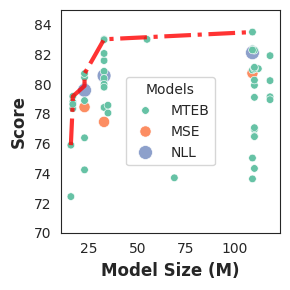

In [40]:

sns.set_style("white")

fig, ax = plt.subplots(1, 1, figsize=(3, 3))

df_avg = df_melted.groupby(['Model', 'loss']).mean(numeric_only=True)
df_avg = df_avg.reset_index()

# rename loss
df_avg['loss'] = df_avg['loss'].replace({"N/A": "MTEB"})
# rename column loss
df_avg = df_avg.rename(columns={"loss": "Models"})

# keep only less than 50M 
df_avg = df_avg[df_avg['Model Size (Million Parameters)'] <= 120]
df_avg = df_avg.dropna()


sns.scatterplot(data=df_avg, x='Model Size (Million Parameters)', y='Score', hue='Models', size="Models",
                sizes=(100, 30), ax=ax, palette="Set2")


def trace_pareto_frontier(df, x, y, ax):
    df = df.sort_values(x)
    pareto_front = [df.iloc[0]]
    for i in range(1, len(df)):
        if df.iloc[i][y] >= pareto_front[-1][y]:
            pareto_front.append(df.iloc[i])
    pareto_front = pd.DataFrame(pareto_front)
    ax.plot(pareto_front[x], pareto_front[y], 'red', linestyle="-.", lw=3, alpha=0.8)


trace_pareto_frontier(df_avg, 'Model Size (Million Parameters)', 'Score', ax)

# Change label sizes
ax.set_xlabel("Model Size (M)", fontsize=12, fontweight='bold')
ax.set_ylabel("Score", fontsize=12, fontweight='bold')


# set ylim
ax.set_ylim(70, 85)

# export
fig.tight_layout()
fig.savefig(EXPORT_PATH_FIG / "pareto_frontier_sts_nlp_less_110.png")

